In [1]:
import sys
sys.path.append('/home/hashmi/ResearchBook/Tracking/Notebooks')
from central_import import *

figure_directory = '../../Figures/FinalModel/'
os.makedirs(figure_directory,exist_ok=True)
set_plot_style()

In [2]:
#Calling the input file and shuffling the dataset
data = pd.read_parquet('../DataBuild/DownstreamTrackTrainingData.parquet').sample(frac=1,random_state=51)

In [3]:
x=data.drop(['isMatched'],axis=1)
y=data['isMatched']

columns=np.array(['P','Pt','Tx','Ty', 'X','Y','Eta','Phi','nUTHits','Chi2PerDoF'])
x.columns=columns

#Training Data
print(f"Dimension of the Data is : ",x.shape)
display(x.head())


Dimension of the Data is :  (55502, 10)


,P,Pt,Tx,Ty,X,Y,Eta,Phi,nUTHits,Chi2PerDoF
29055,12036.225731,441.439316,-0.008233,-0.035765,-14.409651,-85.211197,3.998446,-1.797049,4,0.573259
364,10226.238916,216.763108,-0.002195,0.021088,-9.130033,50.204380,4.546942,1.674532,4,0.274051
52050,4525.161110,690.376942,0.080474,-0.131736,192.606689,-308.244781,2.567447,-1.022417,4,0.158477
48683,1699.675633,173.988433,-0.090601,0.048797,-262.288910,139.731888,2.969721,2.647554,4,0.875791
41671,21602.894387,1136.739709,-0.025342,0.046198,-55.272568,106.054962,3.637117,2.072528,4,0.205129


In [4]:
#Train-Test-Evaluation Split
x_train,x_temp,y_train,y_temp=train_test_split(x,y,stratify=y,random_state=35)
x_test,x_eval,y_test,y_eval=train_test_split(x_temp,y_temp,stratify=y_temp,random_state=35)

#Preprocessing of Train-Test Data
x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=x.columns)
x_test=pd.DataFrame(scaler.transform(x_test),columns=x.columns)
x_eval=pd.DataFrame(scaler.transform(x_eval),columns=x.columns)
x_train,y_train=sampler.fit_resample(x_train,y_train)
x_eval,y_eval=sampler.fit_resample(x_eval,y_eval)

#Catboost Pool Functionality
train_data=Pool(data=x_train,label=y_train)
test_data=Pool(data=x_test,label=y_test)
eval_data=Pool(data=x_eval,label=y_eval)

In [5]:
#Catboost Parameters for Training after Hyper-parameter Tuning.
catboost_params = {
    'eval_metric': 'AUC',
    'thread_count': 10,
    'min_data_in_leaf': 2, 
    'learning_rate': 0.1,
    'l2_leaf_reg': 5,
    'iterations': 1000,
    'depth': 8,
    'border_count': 128
    }

#Model Training
model = CatBoostClassifier(**catboost_params)
model.fit(train_data,eval_set=test_data,verbose=100,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7574054	best: 0.7574054 (0)	total: 51.1ms	remaining: 51.1s
100:	test: 0.8050776	best: 0.8050776 (100)	total: 464ms	remaining: 4.13s
200:	test: 0.8096331	best: 0.8108999 (183)	total: 952ms	remaining: 3.78s
300:	test: 0.8121612	best: 0.8123283 (297)	total: 1.58s	remaining: 3.67s
400:	test: 0.8127832	best: 0.8127832 (400)	total: 2.07s	remaining: 3.09s
500:	test: 0.8113563	best: 0.8131099 (404)	total: 2.49s	remaining: 2.48s
600:	test: 0.8122407	best: 0.8131099 (404)	total: 2.96s	remaining: 1.96s
700:	test: 0.8135159	best: 0.8135159 (700)	total: 3.35s	remaining: 1.43s
800:	test: 0.8135863	best: 0.8138122 (770)	total: 3.77s	remaining: 936ms
900:	test: 0.8128682	best: 0.8138122 (770)	total: 4.2s	remaining: 462ms
999:	test: 0.8125685	best: 0.8138122 (770)	total: 4.62s	remaining: 0us

bestTest = 0.8138121524
bestIteration = 770

Shrink model to first 771 iterations.


ROC-AUC Score :  73.94 %
F1 Score :  85.63 %


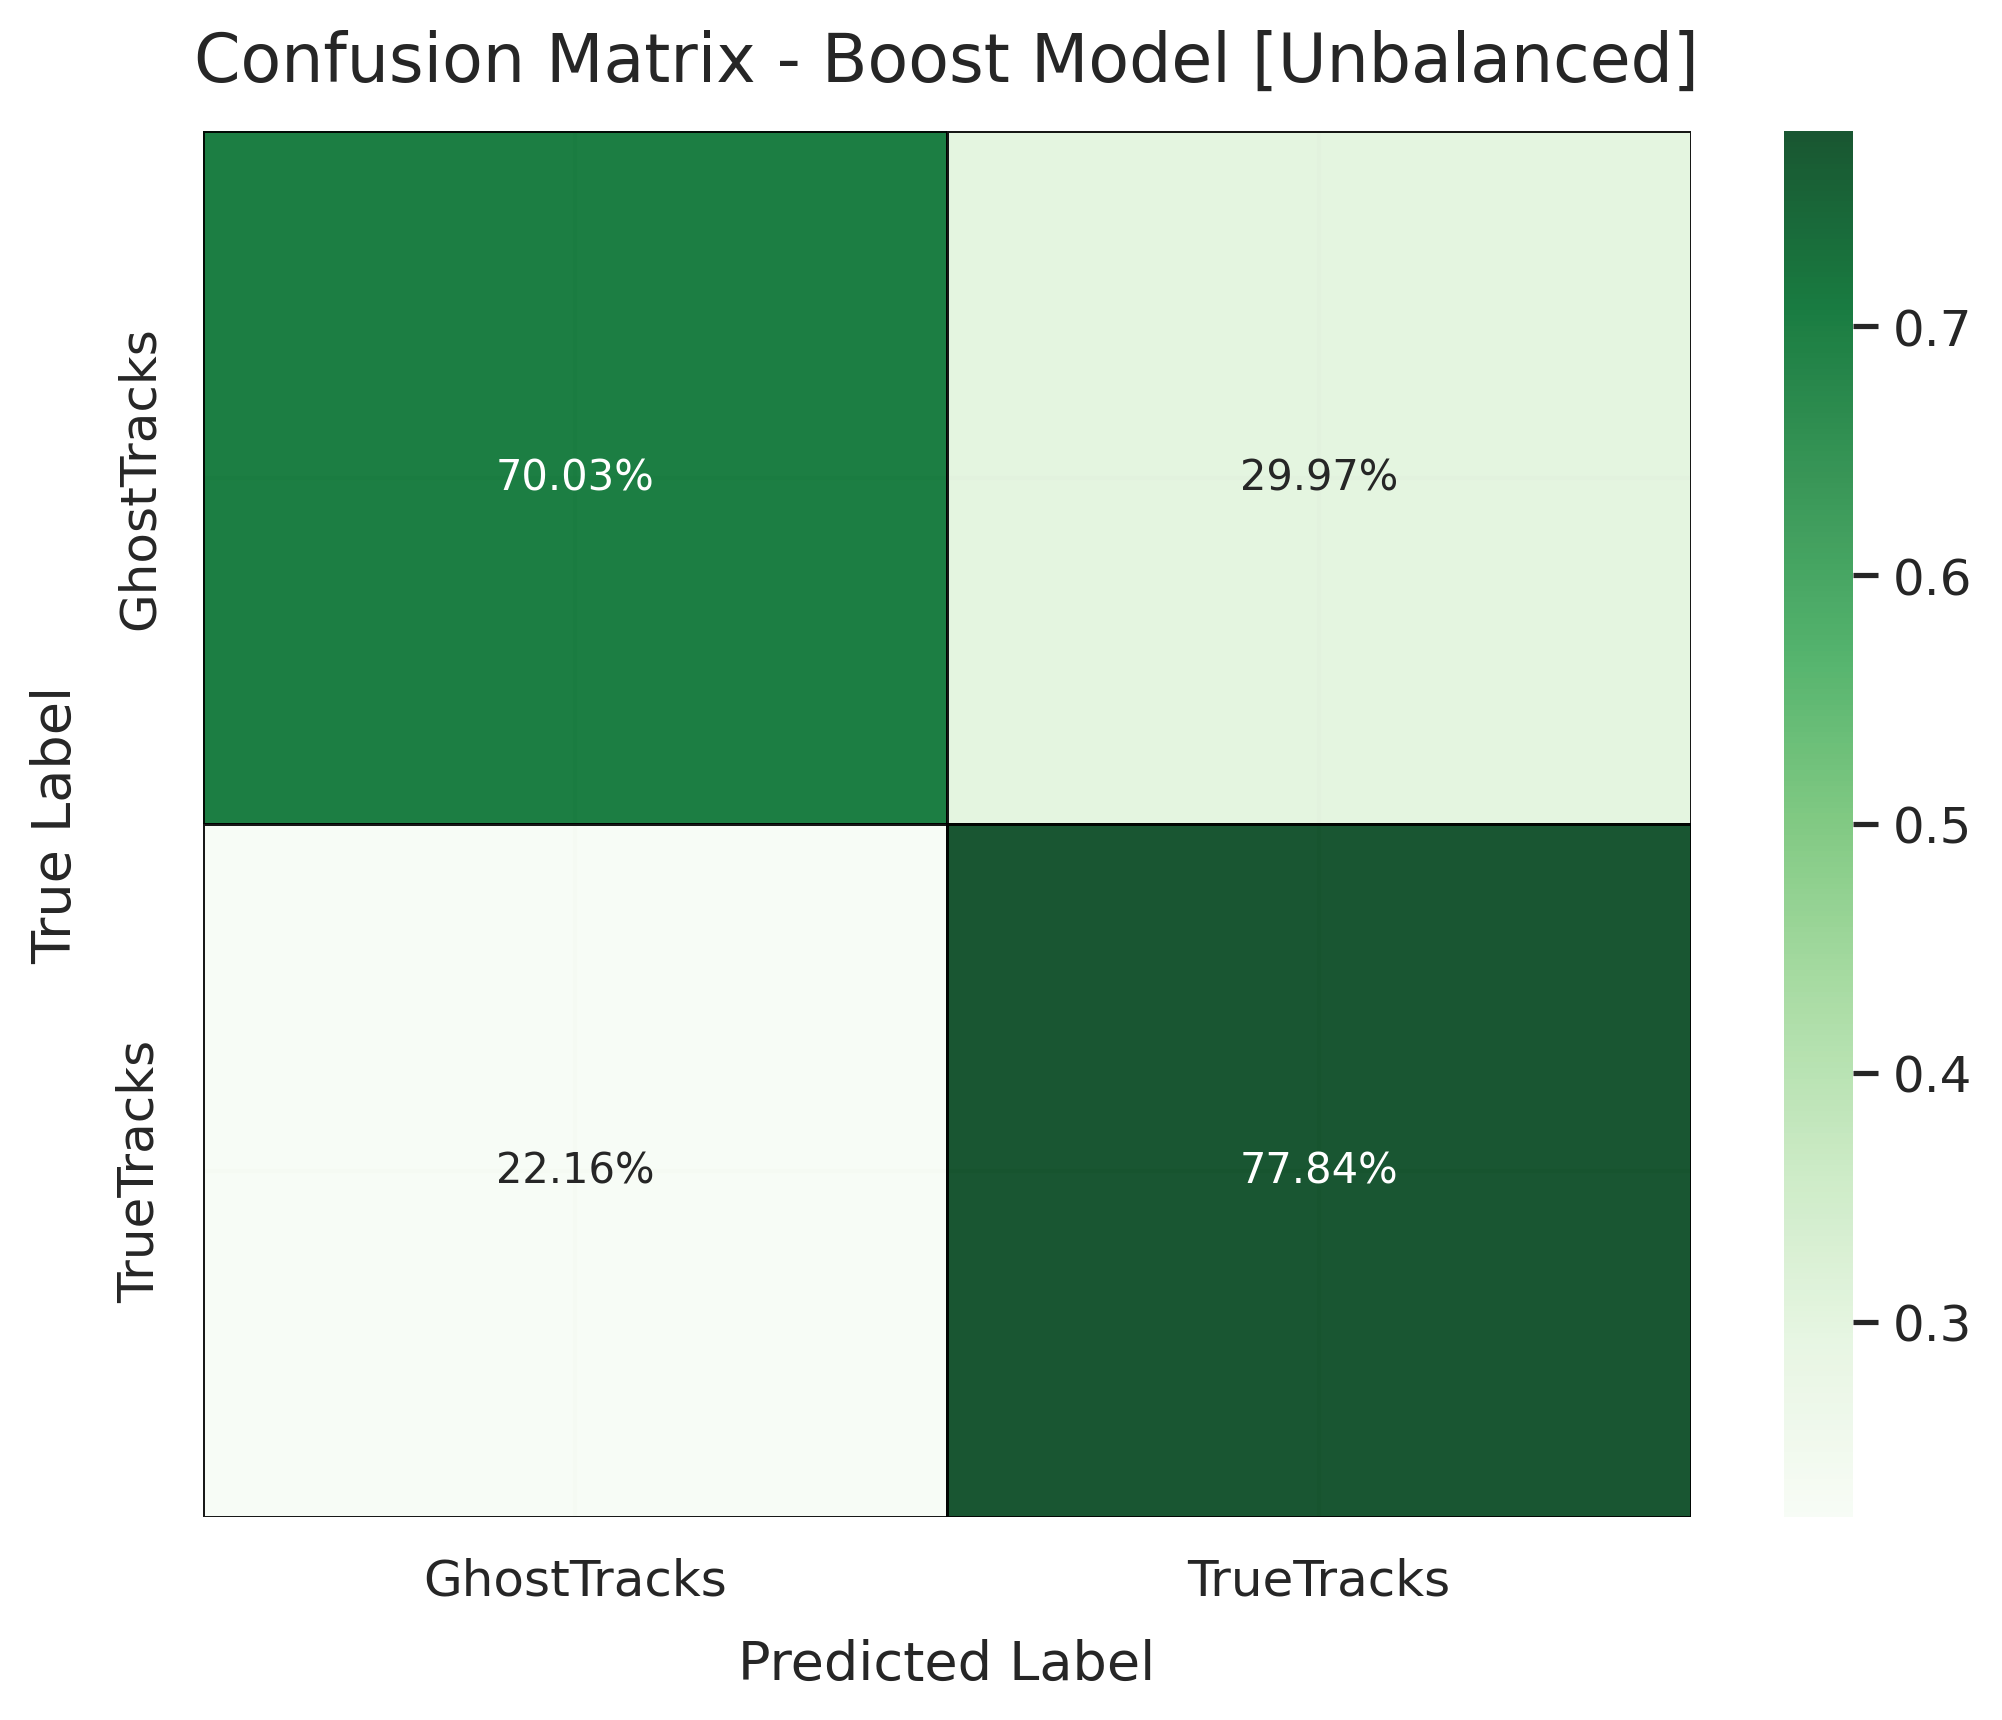

In [6]:
# Model Evaluation (UnBalanced Data)
y_predict=model.predict(x_test)
print(f'ROC-AUC Score : ',round(roc_auc_score(y_test,y_predict)*100,2),'%')
print(f'F1 Score : ',round(f1_score(y_test,y_predict)*100,2),'%')

# ConfusionMatrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_predict,normalize='true'), xticklabels=['GhostTracks', 'TrueTracks'],yticklabels=['GhostTracks', 'TrueTracks'], fmt='.2%',annot=True, annot_kws={'fontsize': 10}, 
            cmap='Greens',linewidths=0.7,linecolor='black',alpha=0.9)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Boost Model [Unbalanced]')
plt.savefig(f"{figure_directory}/Downstream_Catboost_CM_Unbalanced.png")
plt.show()

ROC-AUC Score :  75.12 %
F1 Score :  75.54 %


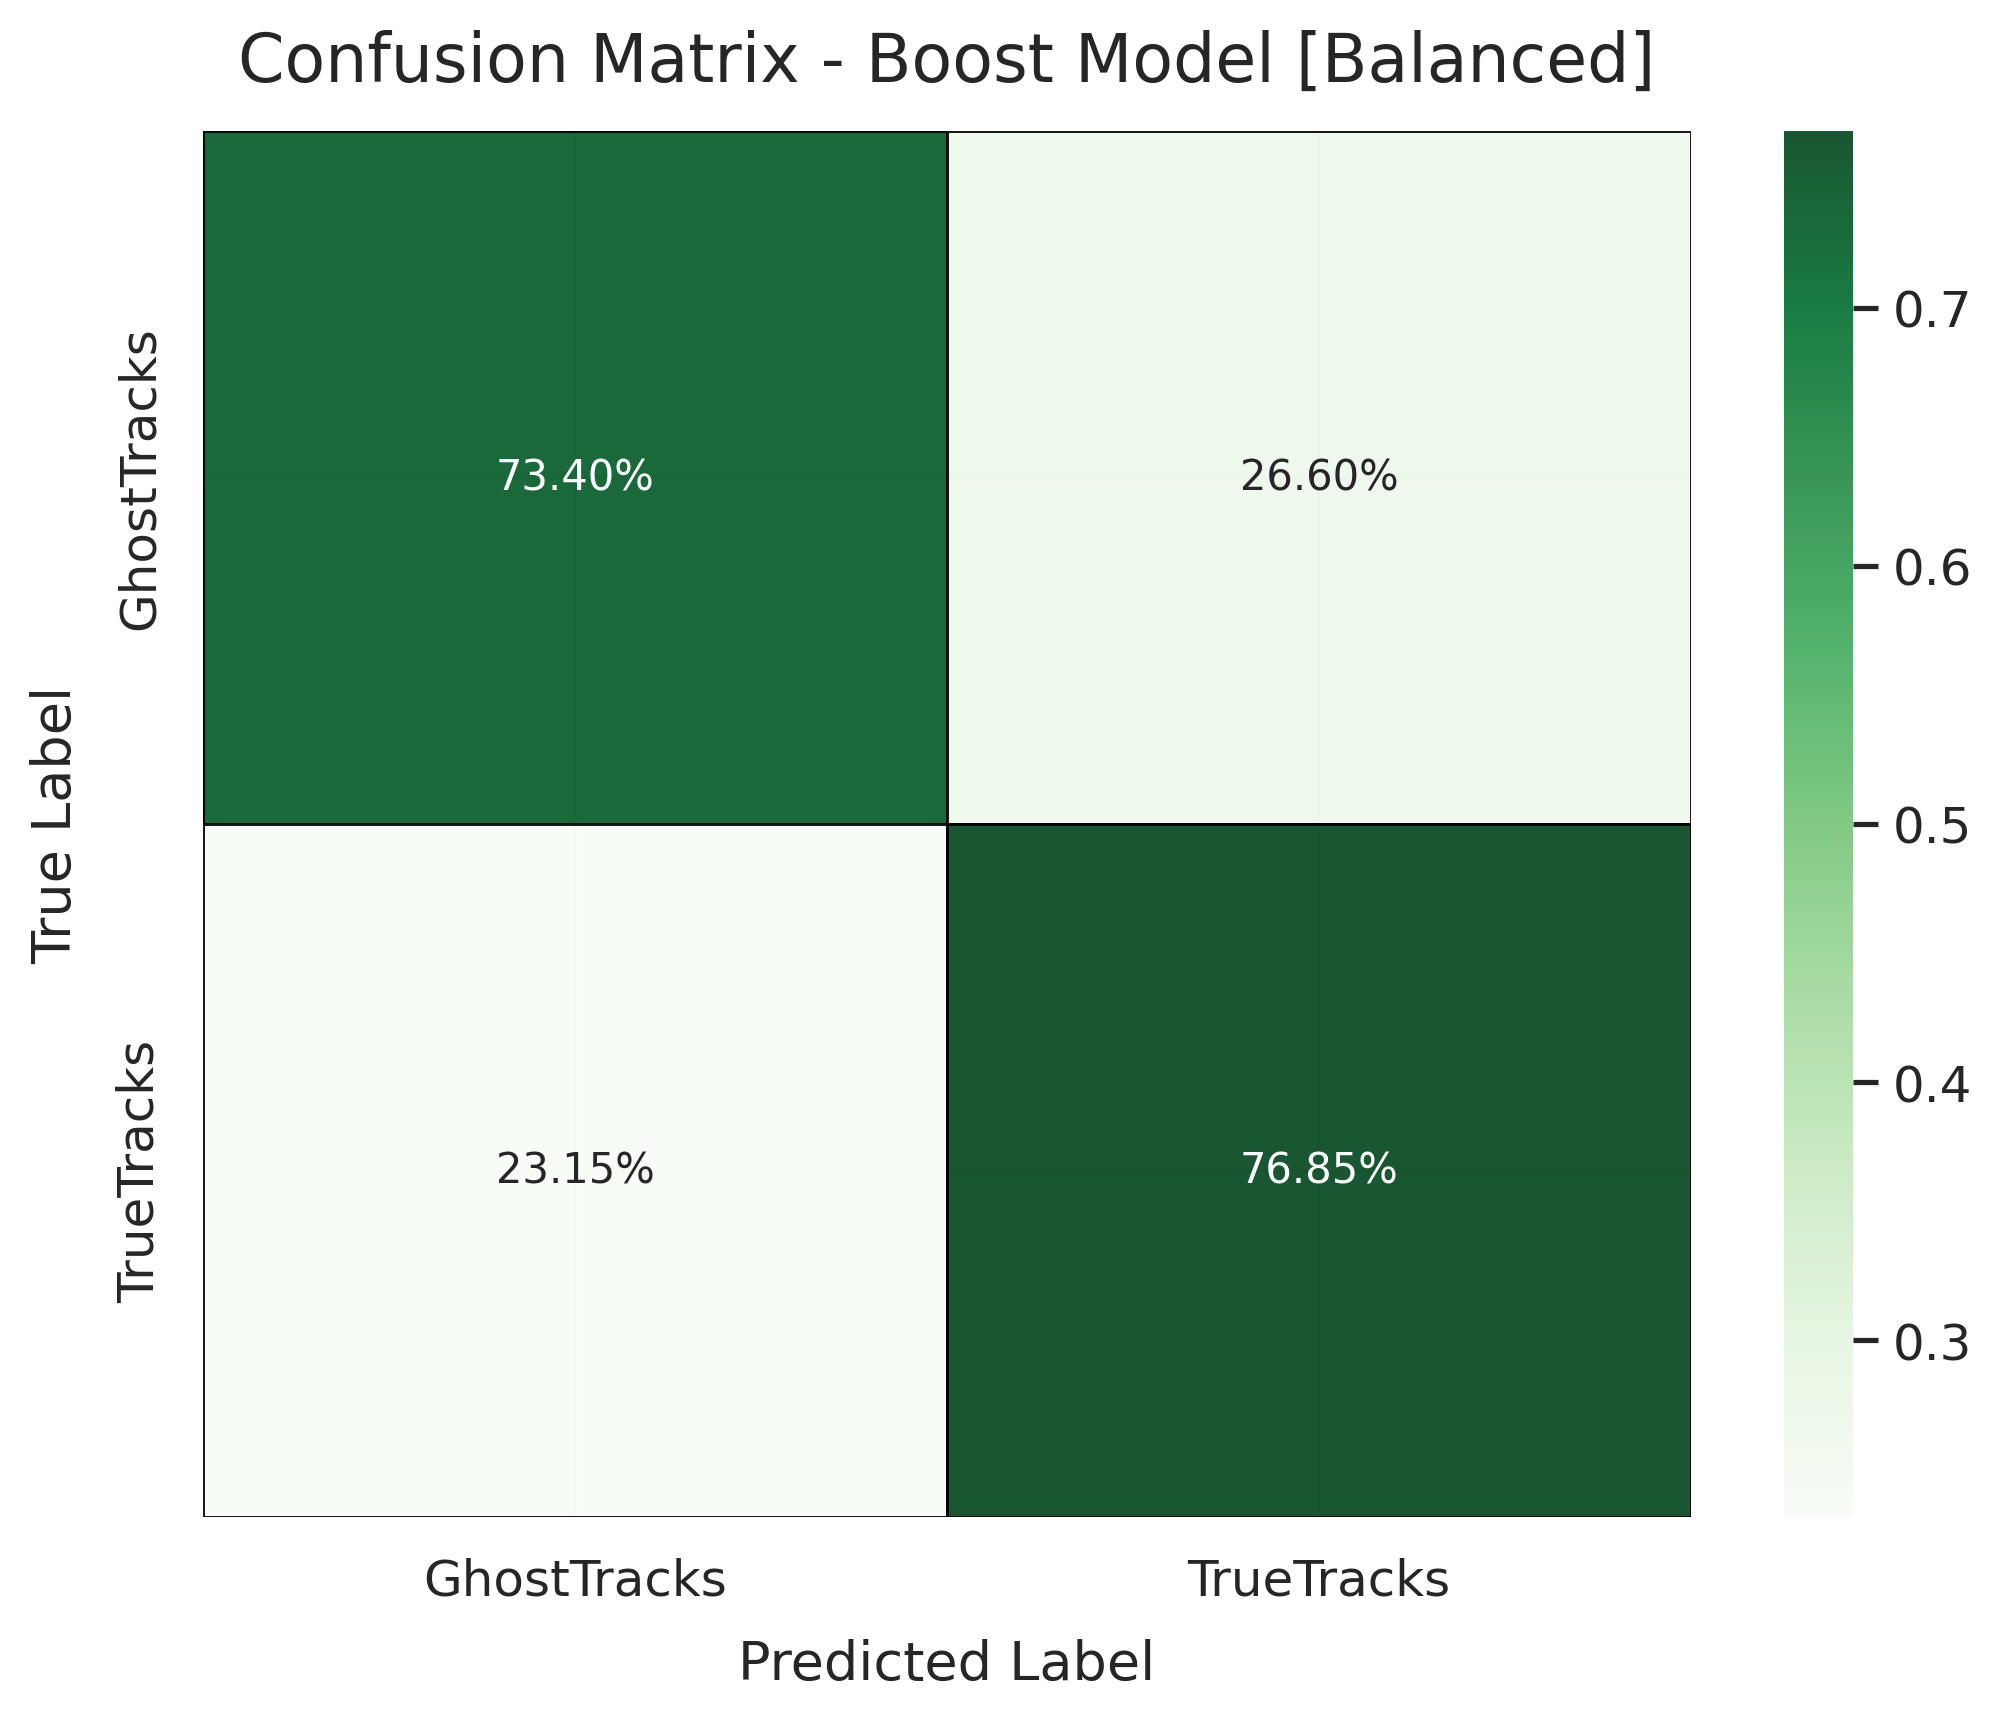

In [7]:
# Model Evaluation (Balanced Data)
y_predict=model.predict(x_eval)
print(f'ROC-AUC Score : ',round(roc_auc_score(y_eval,y_predict)*100,2),'%')
print(f'F1 Score : ',round(f1_score(y_eval,y_predict)*100,2),'%')

# ConfusionMatrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_eval, y_predict,normalize='true'), xticklabels=['GhostTracks', 'TrueTracks'],yticklabels=['GhostTracks', 'TrueTracks'], fmt='.2%',annot=True, annot_kws={'fontsize': 10}, 
            cmap='Greens',linewidths=0.7,linecolor='black',alpha=0.9)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Boost Model [Balanced]')
plt.savefig(f"{figure_directory}/Downstream_Catboost_CM_Balanced.png")
plt.show()


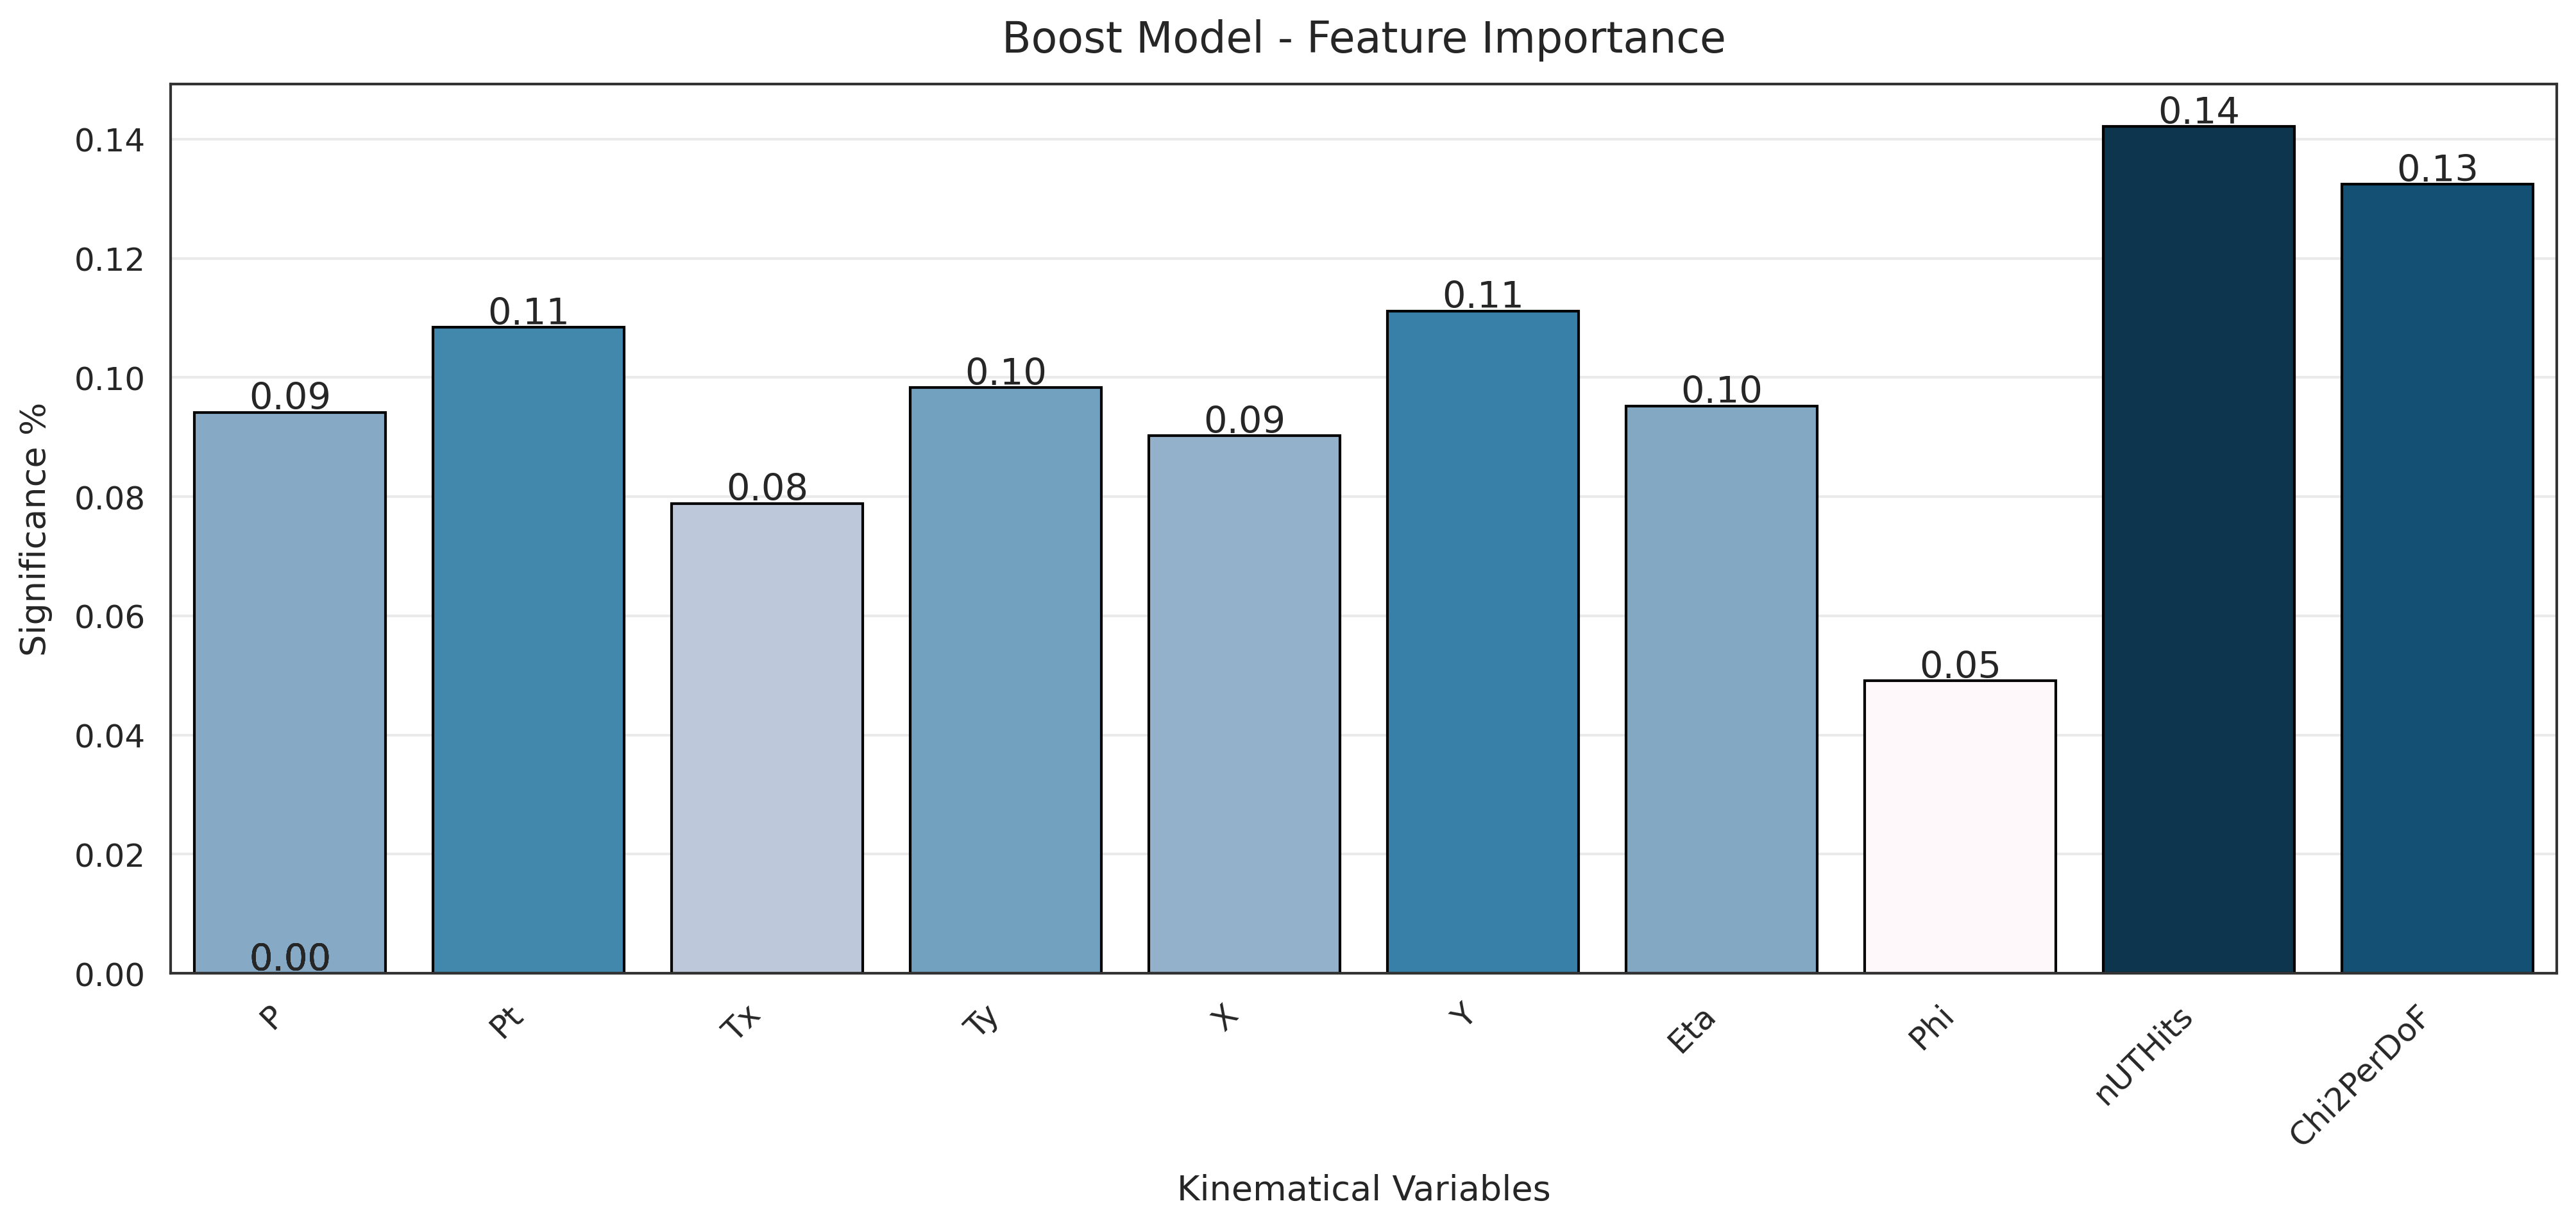

In [8]:
# FeatureImportance
plt.figure(figsize=(16, 6))
featureImportance = model.feature_importances_ / np.sum(model.feature_importances_)

ax=sns.barplot(x=columns, y=featureImportance,hue=model.feature_importances_,edgecolor='black',palette='PuBu')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')
plt.title('Boost Model - Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Kinematical Variables')
plt.ylabel('Significance %')
ax.legend_.remove()
plt.savefig(f"{figure_directory}/Downstream_Catboost_FI.png")
plt.show()


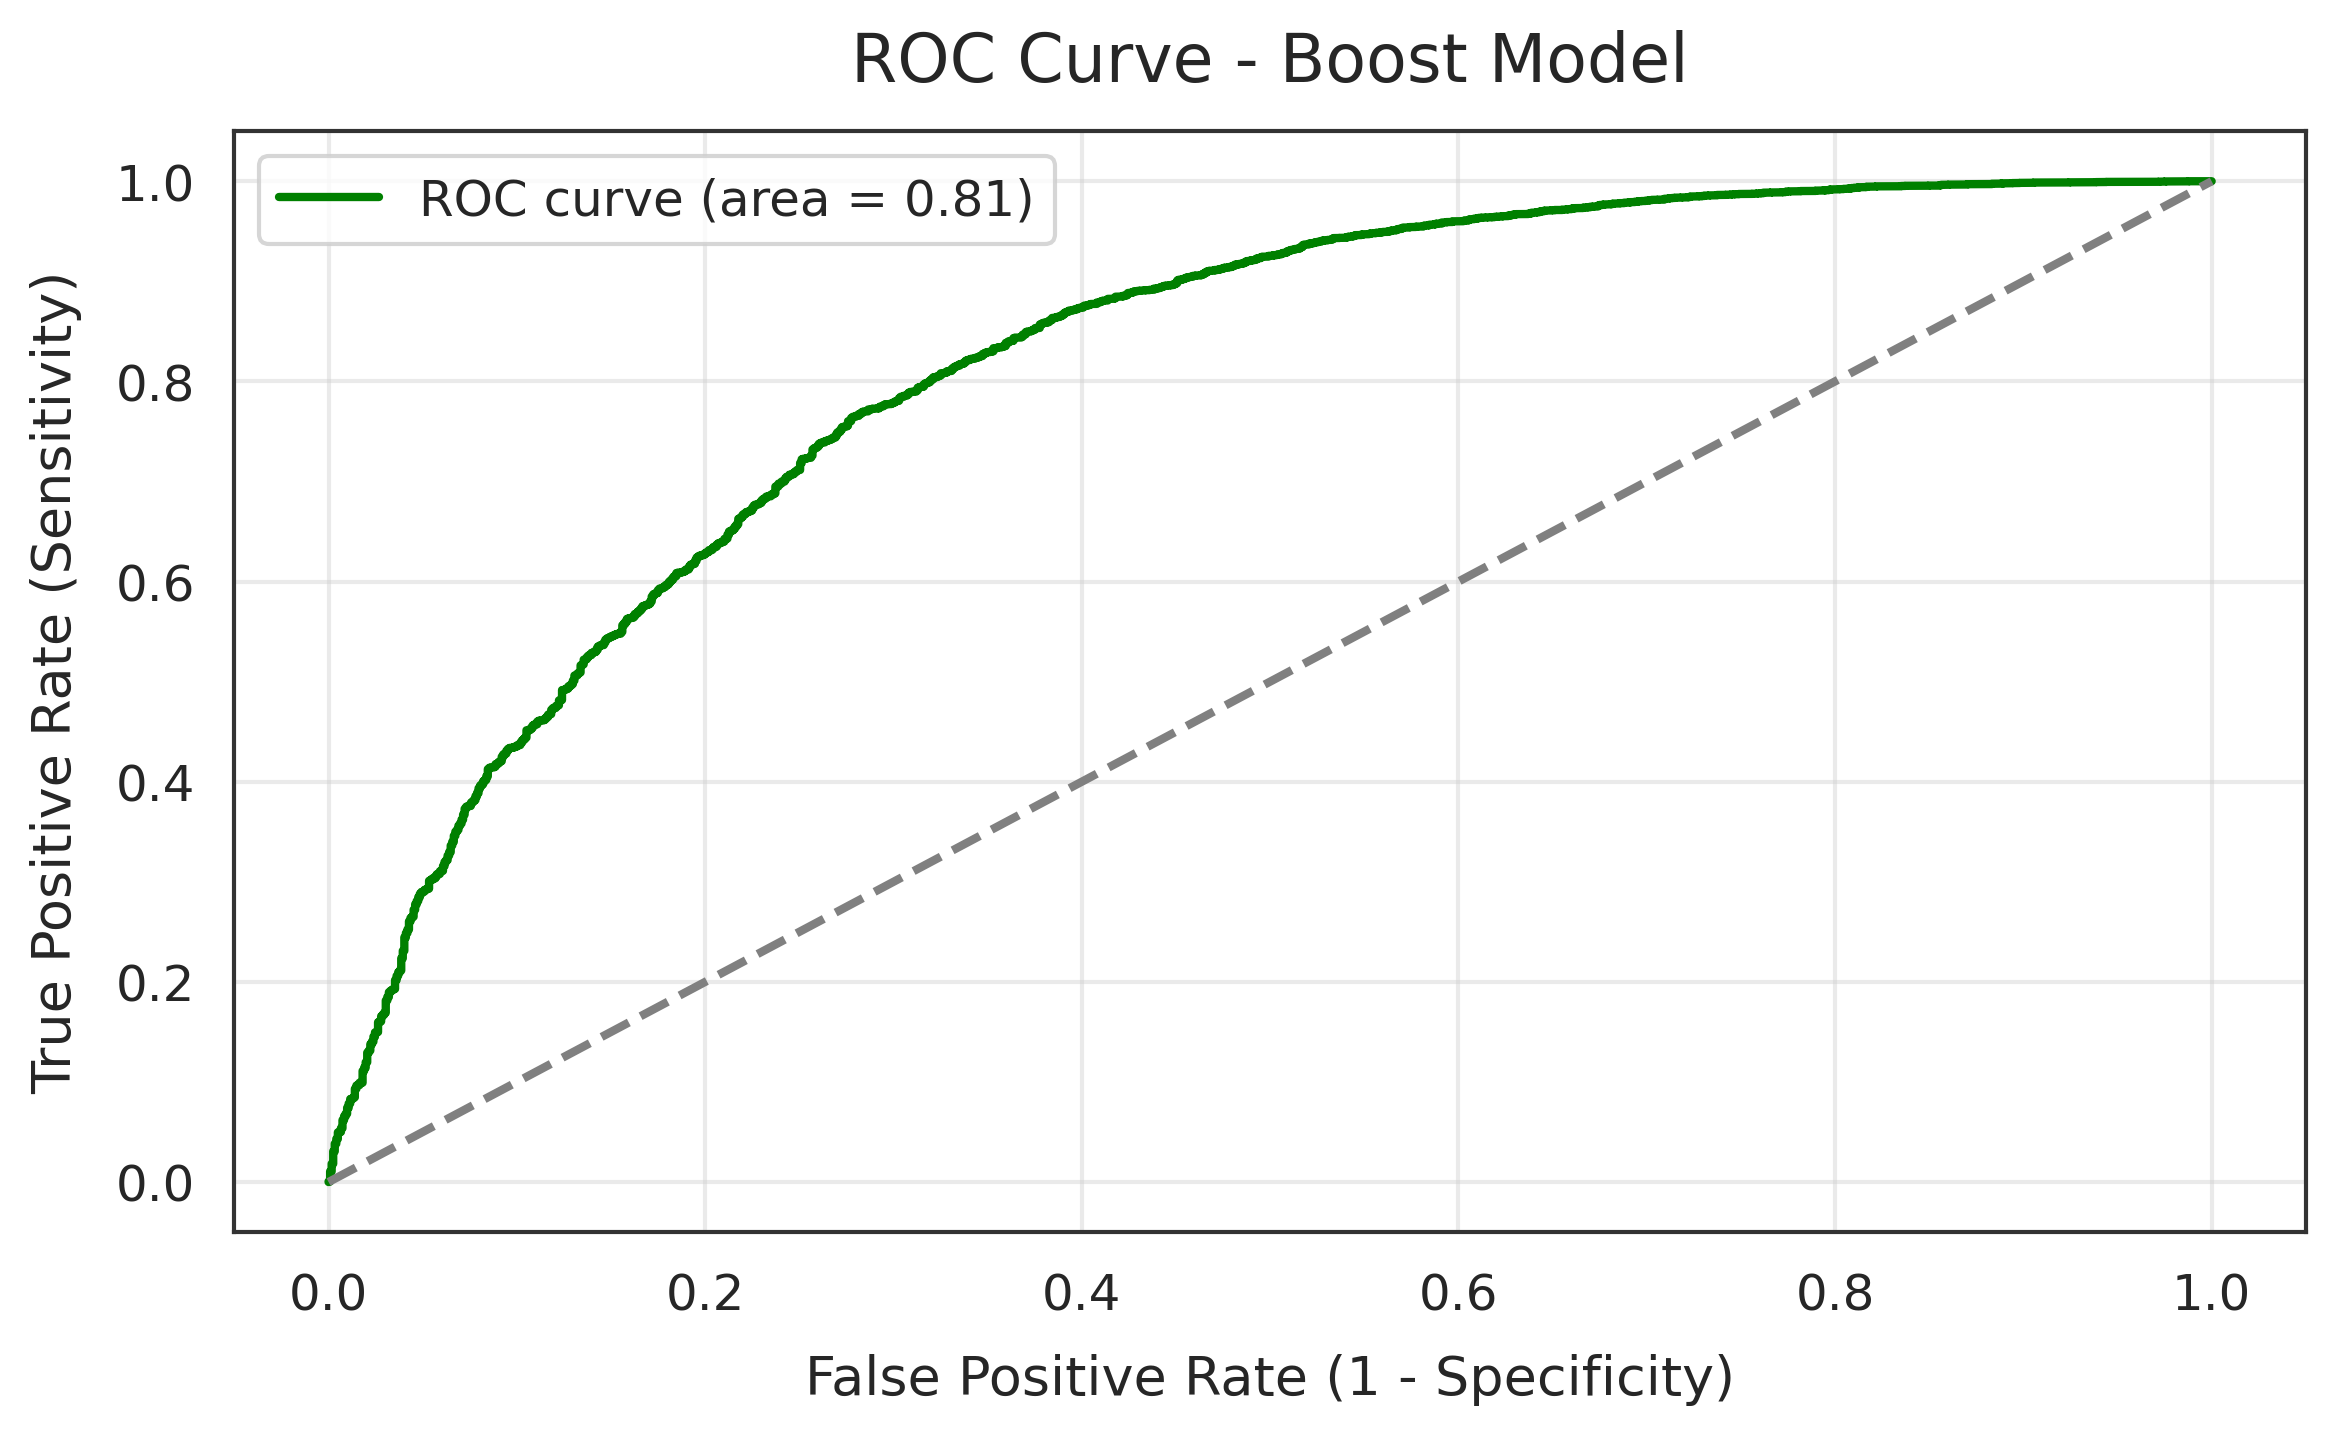

In [9]:
from sklearn.metrics import roc_curve,auc

evaluation=x_test.copy()

probabilityValue = model.predict_proba(evaluation)[:,1] #First Probability will make the plot upside down
fpr, tpr, threshold =roc_curve(y_test,  probabilityValue)

plt.figure(figsize=(8, 5))
plt.title('ROC Curve - Boost Model')
plt.plot(fpr, tpr,color='Green',label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig(f"{figure_directory}/Downstream_Catboost_ROC.png")
plt.show()



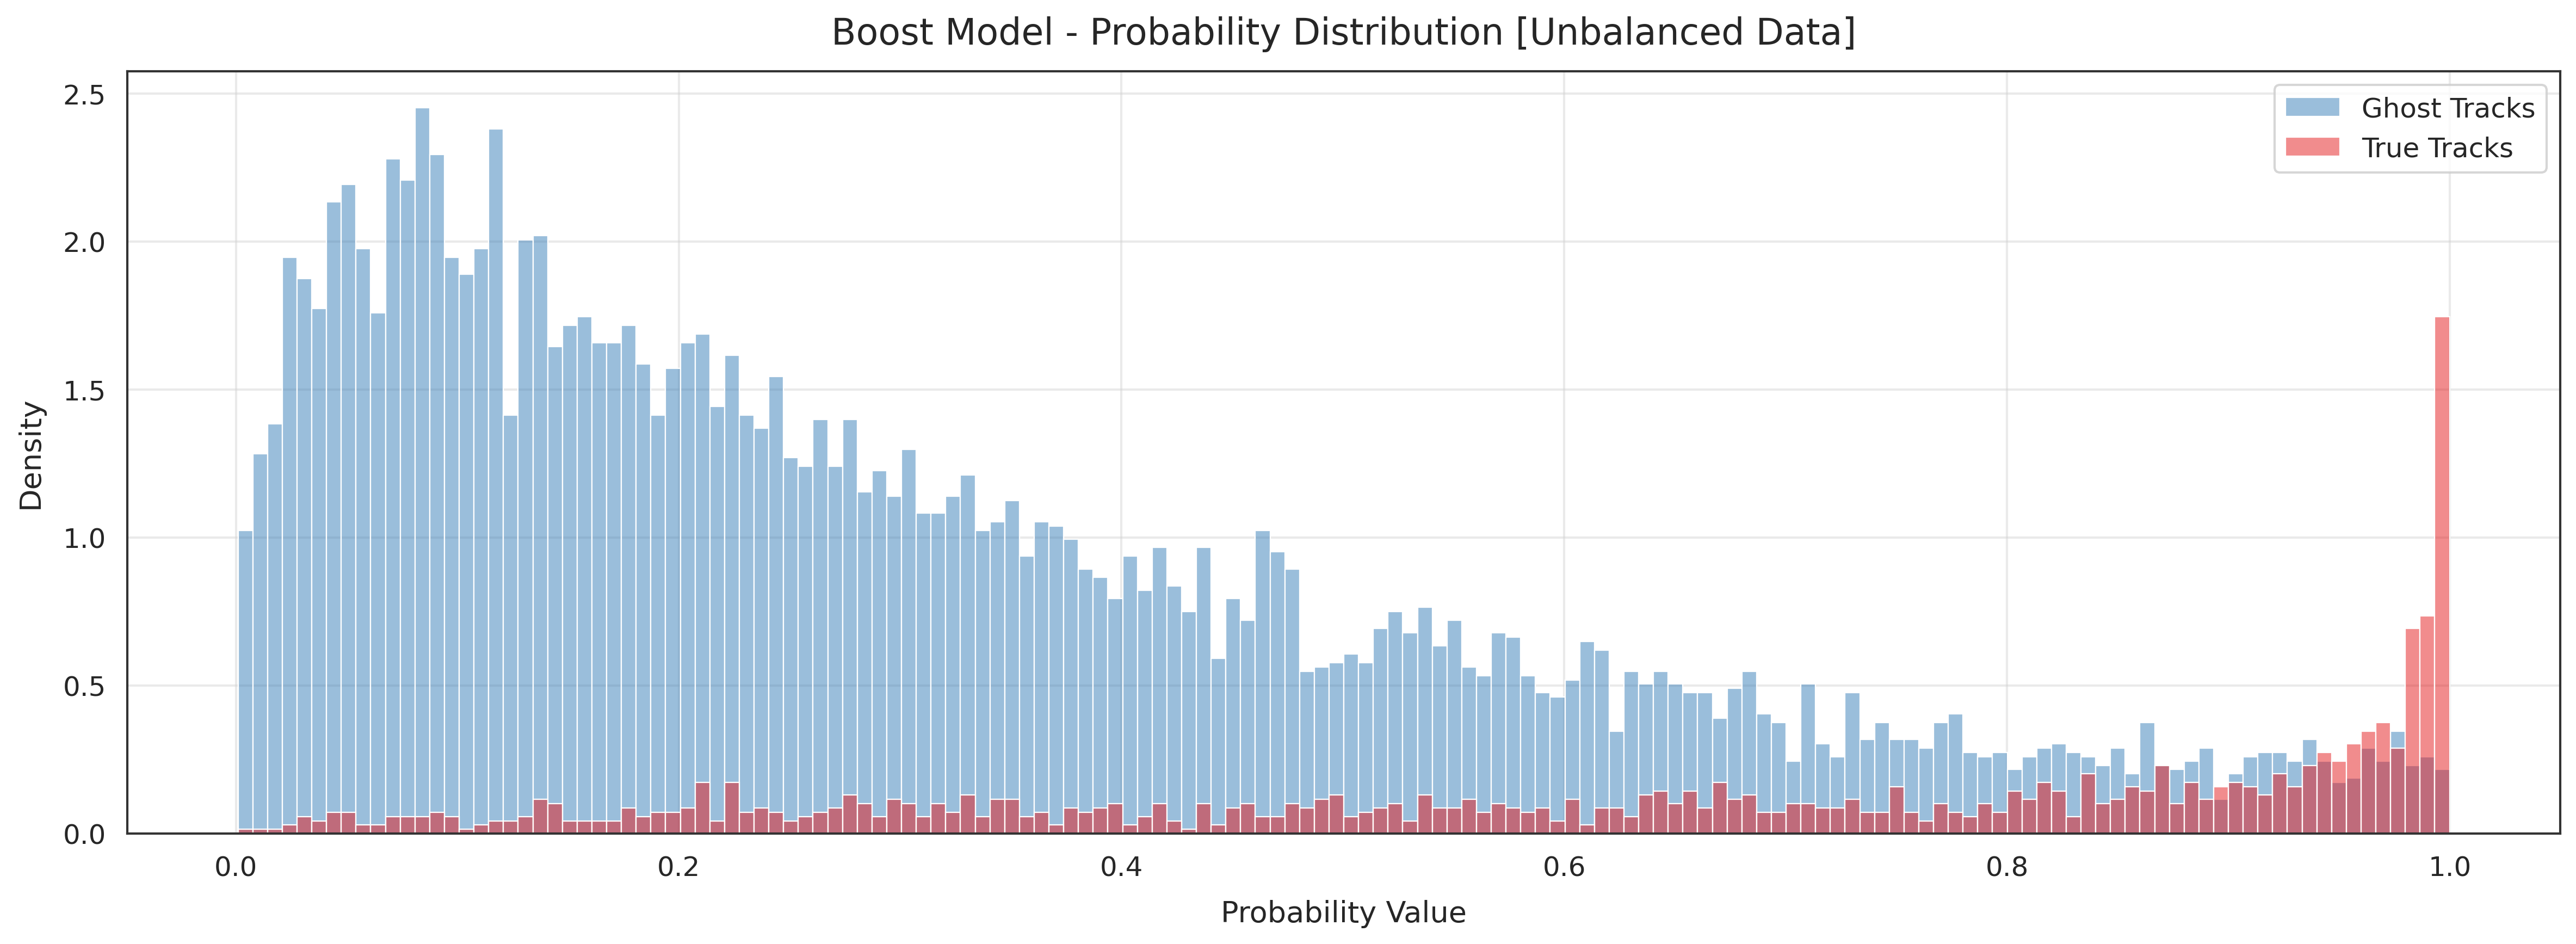

In [10]:
evaluation=x_test.copy()

probabilityValue = model.predict_proba(evaluation)[:,0] #Keeping the first set of probability for the distribution analysis
evaluation['ProbabilityValues']=probabilityValue
evaluation['TrueLabels']=y_test.values

plt.figure(figsize=(16, 6))
plt.title('Boost Model - Probability Distribution [Unbalanced Data]')
sns.histplot( x=evaluation['ProbabilityValues'], hue=evaluation['TrueLabels'], stat='density', bins=150, palette='Set1')
plt.xlabel('Probability Value')
plt.legend(labels=['Ghost Tracks', 'True Tracks'])
plt.savefig(f"{figure_directory}/Downstream_Catboost_ProbDist_Unbalanced.png")
plt.tight_layout()
plt.show()

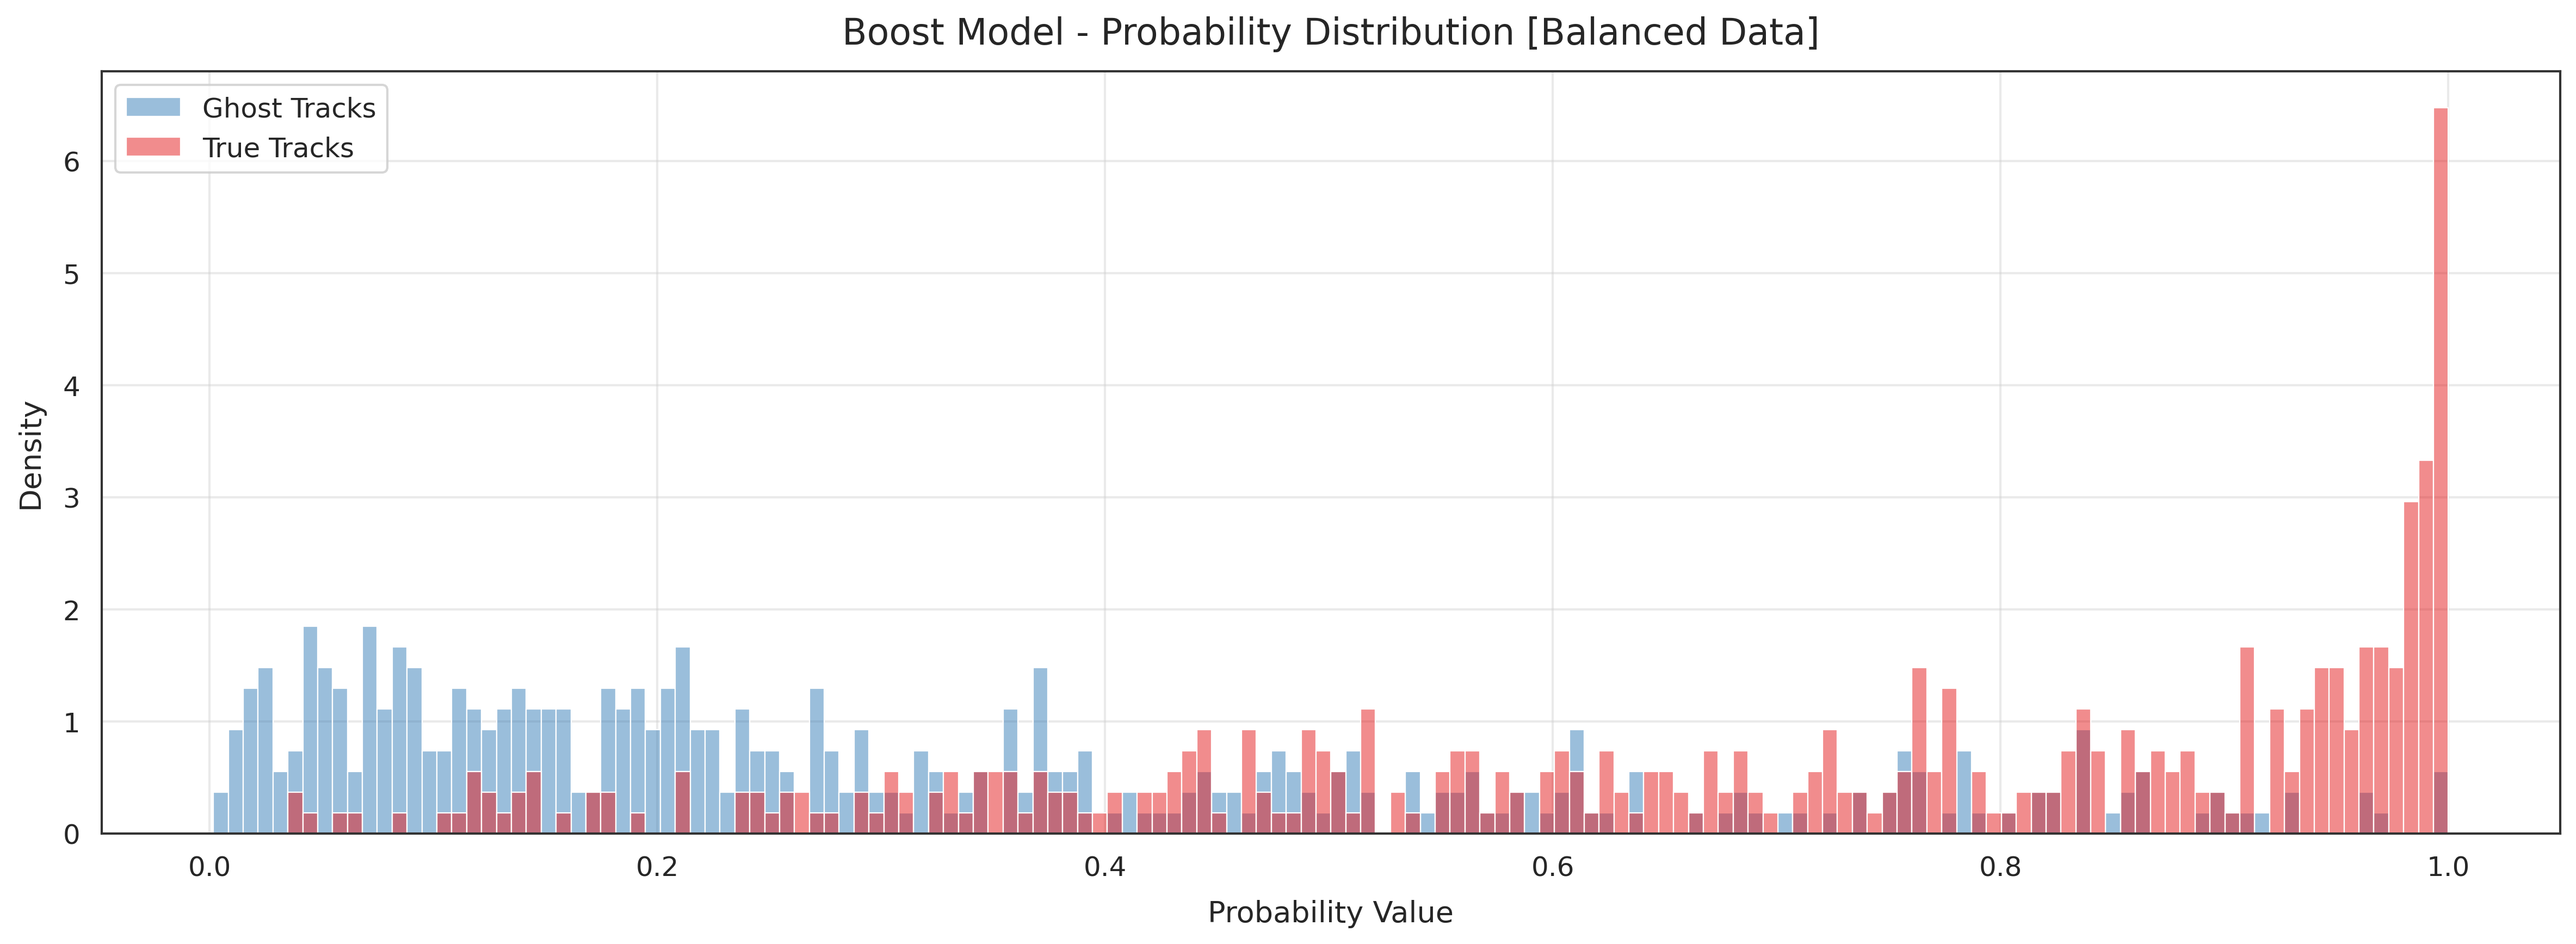

In [11]:
evaluation=x_eval.copy()

probabilityValue = model.predict_proba(evaluation)[:,0] #Keeping the first set of probability for the distribution analysis
evaluation['ProbabilityValues']=probabilityValue
evaluation['TrueLabels']=y_eval.values

plt.figure(figsize=(16, 6))
plt.title('Boost Model - Probability Distribution [Balanced Data]')
sns.histplot( x=evaluation['ProbabilityValues'], hue=evaluation['TrueLabels'], stat='density', bins=150, palette='Set1')
plt.xlabel('Probability Value')
plt.legend(labels=['Ghost Tracks', 'True Tracks'])
plt.savefig(f"{figure_directory}/Downstream_Catboost_ProbDist_Balanced.png")
plt.tight_layout()
plt.show()

In [12]:
scaler.data_min_

array([ 1.39516465e+03,  1.62111719e+01, -3.79600912e-01, -2.64249146e-01,
       -7.68932007e+02, -6.04244141e+02,  1.61681553e+00, -3.14102750e+00,
        3.00000000e+00,  8.15750659e-03])

In [13]:
scaler.data_max_

array([2.91711541e+05, 1.69255018e+04, 4.13314939e-01, 2.60700315e-01,
       7.64626526e+02, 6.07701111e+02, 5.82174739e+00, 3.14141093e+00,
       8.00000000e+00, 4.96374464e+00])

In [14]:
model.save_model('./DownstreamModel.cpp',format='cpp',pool=train_data)

In [15]:
#Evaluation
input_data = np.zeros(10)

input_data_df = pd.DataFrame(input_data.reshape(1, -1), columns=columns)  # Use the correct column names
input_data_scaled = scaler.transform(input_data_df)  # Transform the data using the scaler

probability = model.predict_proba(input_data_scaled)  # Get the probabilities
print("Probability of GhostTrack: ", probability[0][0])
print("Probability of TrueTrack: ", probability[0][1])


Probability of GhostTrack:  0.9947696895974124
Probability of TrueTrack:  0.0052303104025875425


In [16]:
#End of Notebook